In [9]:
# import
import os,sys
import numpy as np
import joblib
import torch
from tqdm import tqdm

import matplotlib as mpl
import matplotlib as plt
import matplotlib.pyplot as plt

sys.path.append("../models/")
from uncertainty_surrogate_model import UncertaintySurrogateModel
from mdn_model import mdn_mean,variance,aleatoric_uncertainty,epistemic_uncertainty,prediction_interval,quantile
sys.path.append("../utils/")
from process import timeloss_process
sys.path.append("../SUMO/test/")
from runner_snapshot import run_snapshot

In [10]:
# configuration
# mpl.rcParams['font.sans-serif']='SimHei'
mpl.rcParams['font.family'] = ['Times New Roman','SimSun'] 
mpl.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
mpl.rcParams['font.size'] = 9  # 按磅数设置的
mpl.rcParams['figure.dpi'] = 300
cm = 1/2.54  # centimeters in inches
mpl.rcParams['figure.figsize'] = (12*cm,8*cm)
mpl.rcParams['savefig.dpi'] = 900
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'both'
mpl.rcParams['axes.grid.which'] = 'both'
mpl.rcParams['axes.facecolor'] = 'white'

In [11]:
# helper function
def aggregate(a,freq,axis,mode='instantaneous'):
    shp = list(a.shape)
    n = shp[axis] - shp[axis]%freq
    shp[axis] = n
    a = np.stack(np.split(a.take(np.arange(n),axis),n/freq,axis),axis)  # (# (...,n/freq,freq,...))
    shp1 = a.shape
    a = a.sum(axis+1,keepdims=True)  # (...,n/freq,1,...)
    if mode == 'cumulative':
        a = a.cumsum(axis)
    a = np.broadcast_to(a,shp1).reshape(shp)
    
    return a

def control2array(controls):
    control_arrays = []
    for control in controls:
        control_arrays.append(np.concatenate([control['phase'],control['split']]))
    return np.stack(control_arrays,axis=0)

In [218]:
# 导入数据
proposed_name = 'standard-seed-1'
control_dir = "../results/experiment/control/"

with open(control_dir+proposed_name+'/'+'simulation_data.pkl','rb') as f:
    simulation_data = joblib.load(f)
with open(control_dir+proposed_name+'/'+'timestamp_data.pkl','rb') as f:
    timestamp_data = joblib.load(f)
with open(control_dir+proposed_name+'/'+'mpc_data.pkl','rb') as f:
    mpc_data = joblib.load(f)

result_dir = control_dir + proposed_name +'/results/'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

# region
# simulation_data: dict of tc,arrive,queue_length,timeloss,depart
#   tc: list of dict,including phase and split, should be convert to array(13)
#   arrive: list of array(frame_num,4,3)
#   queue_length: list of array(frame_num,4,3)
#   timeloss: list of array(frame_num,4,3)
#   depart: list of array(frame_num,4,3)
# timestamp_data: 开始控制后每个周期结束的时间点，以monitor启动的时刻为零点,list
# mpc_data: surrogate_result, control_result, upper_context, surrogate_model
#   surrogate_result: list of tensor tuple, (c,mu,sigma)
#       c: (lookahead,num_components,1)
#       mu: (lookahead,num_components,1)
#       sigma: (lookahead,num_components,1)
#   control_result: list of tensor of shape (lookahead,13)
#   surrogate_model: simply neural network model
#   context_result: list of context tensors of shape (batch_size,hidden_size)
# endregion

In [226]:
# global parameter
num = 20  # 绘图密度
cycle_index = 24
output_dir = result_dir + f'snapshot_{cycle_index}/'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
step_ahead = 1  # 进行调整的前向位置

##### 一维随机投影方向


In [210]:
# 间隔构建
direction = np.random.RandomState(8).normal(size=(4,8))
direction = direction / (np.linalg.norm(direction) + 1e-16)

control = control2array(simulation_data['tc'][cycle_index-4:cycle_index])  # (lookahead,13)
control[:,5:] = 35.0*np.ones((4,8))
b1 = ((15.0*np.ones((4,8)) - control[:,5:])/direction)
b2 = ((60.0*np.ones((4,8)) - control[:,5:])/direction)
lb = max([b1[direction>0].max(),b2[direction<0].max()])
ub = min([b1[direction<0].min(),b2[direction>0].min()])
print(lb,ub)

x = np.linspace(lb,ub,num)  # 调整范围
controls = np.zeros((num,4,13))
for i,x1 in enumerate(x):
        control = control2array(simulation_data['tc'][cycle_index-4:cycle_index])  # (lookahead,13)
        control[:,5:] += x1*direction
        controls[i] = control[:]

np.save(output_dir+f'control_project_curve.npy',controls)

-55.920637799792516 58.680585963610675


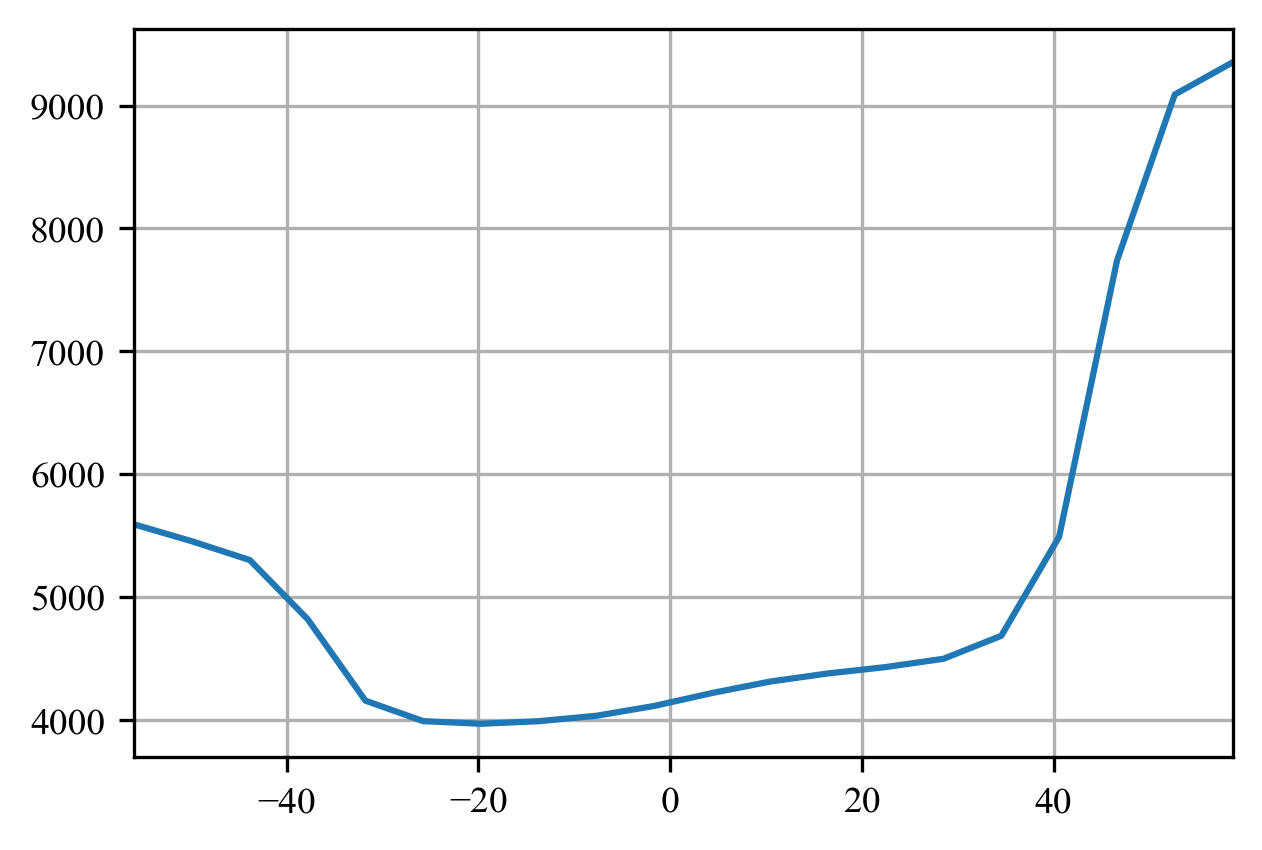

In [211]:
# 代理曲线
x = np.linspace(lb,ub,num)  # 调整范围

controls = np.load(output_dir+'control_project_curve.npy')
res = np.zeros(num)
for i in range(num):
    tc = torch.from_numpy(controls[i]).to(torch.float32).unsqueeze(0)
    with torch.no_grad():
        res[i] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index-4-8],tc))[0,step_ahead]

fig,ax = plt.subplots()
ax.plot(x,res)
ax.set_xlim([lb,ub])
ylim = ax.get_ylim()

(-48.39975069754987, 60.49968837193733)

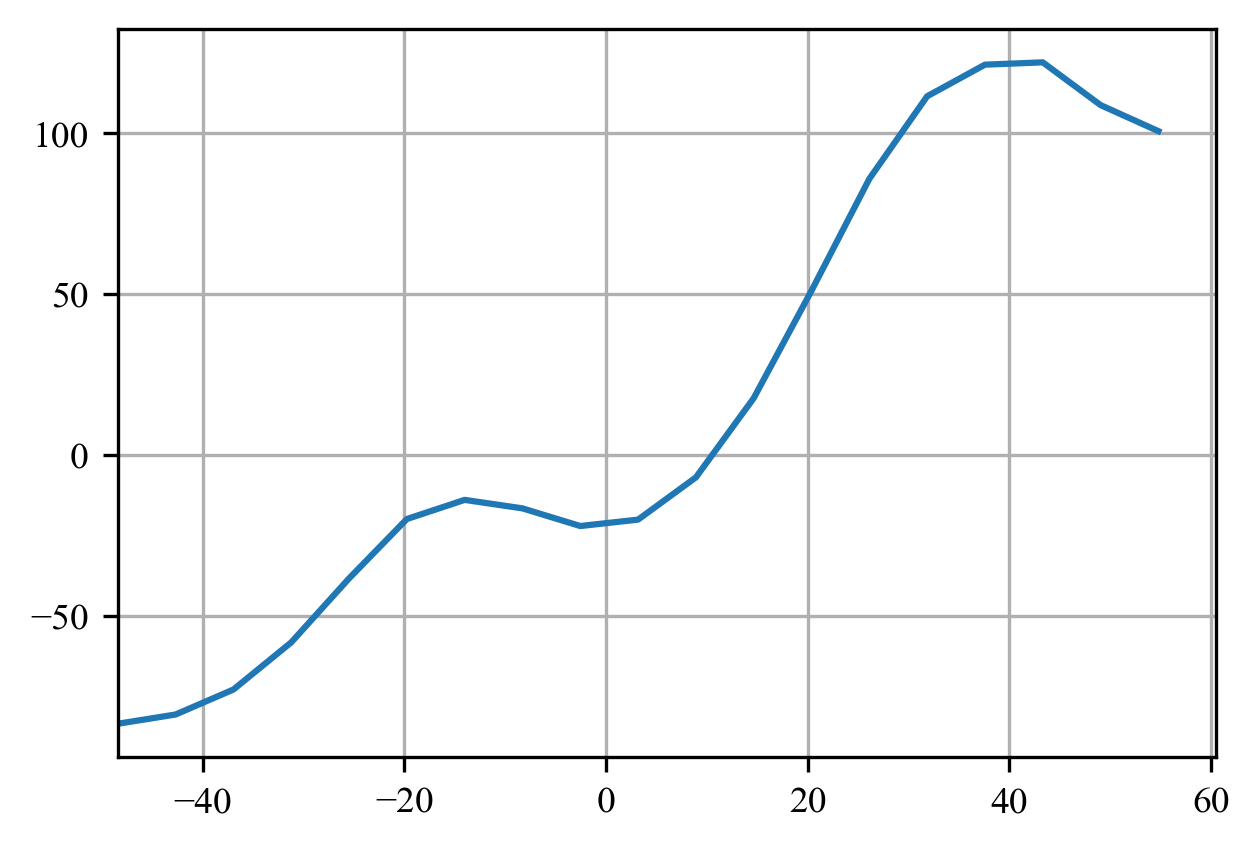

In [52]:
# 代理曲线的差分
x = np.linspace(lb,ub,num)  # 调整范围

controls = np.load(output_dir+'control_project_curve.npy')
res = np.zeros(num)
for i in range(num):
    tc = torch.from_numpy(controls[i]).to(torch.float32).unsqueeze(0)
    with torch.no_grad():
        res[i] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index-4-8],tc))[0,step_ahead]

fig,ax = plt.subplots()
ax.plot(x[:-1],res[1:]-res[:-1])
ax.set_xlim([lb,ub])

(-55.920637799792516, 58.680585963610675)

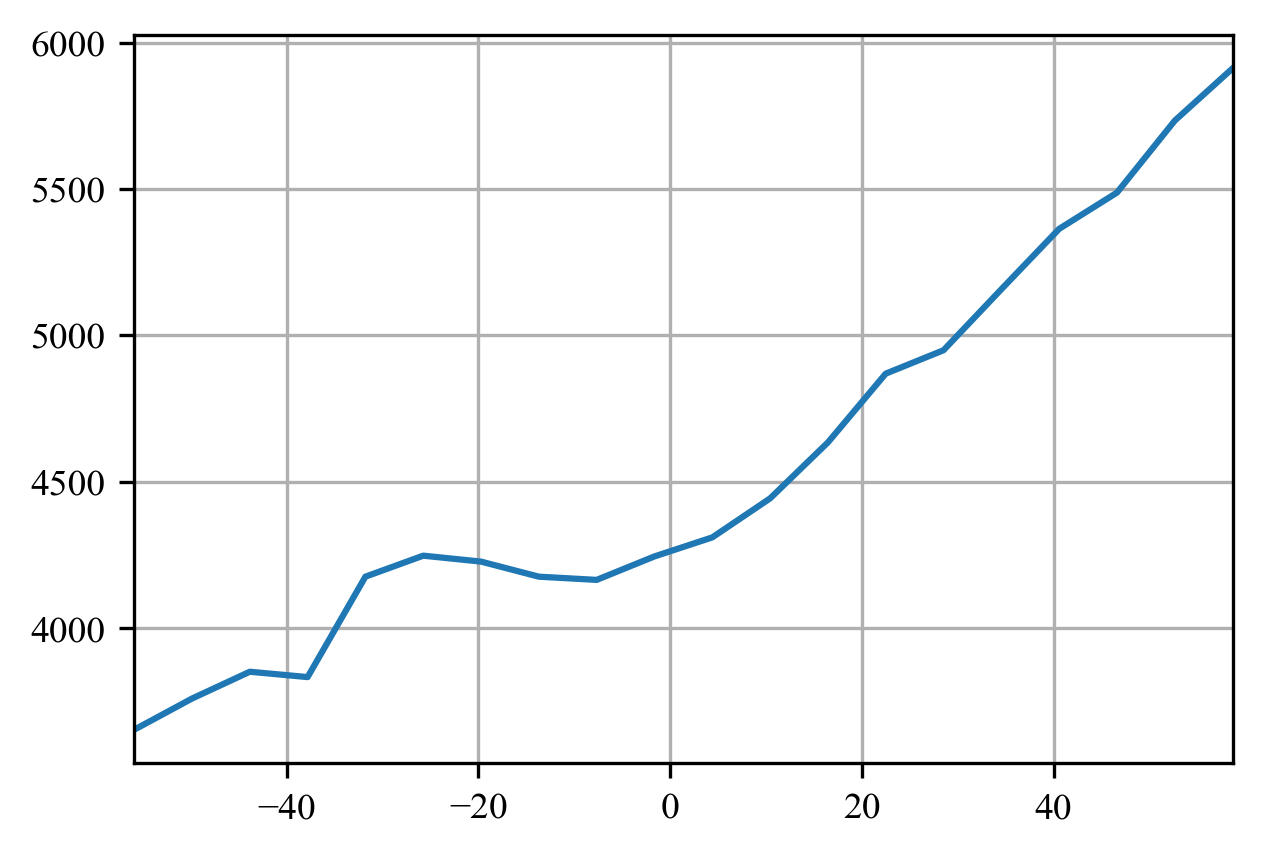

In [212]:
# 真实曲线
with open(output_dir+"res_project_curve.npy",'rb') as f:
    res = np.load(f)
    
fig,ax = plt.subplots()
ax.plot(x,res)
ax.set_xlim([lb,ub])

(-55.920637799792516, 58.680585963610675)

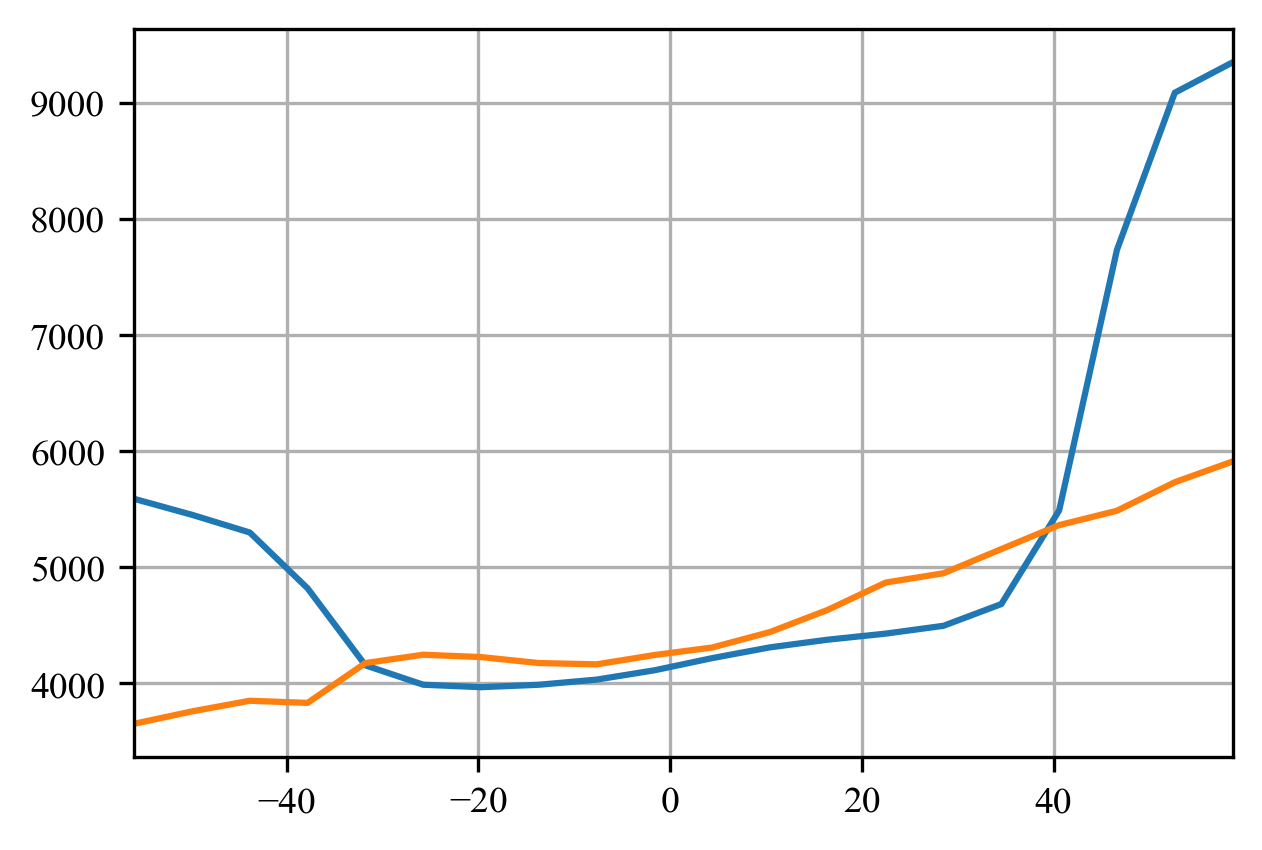

In [213]:
# 对比分析
x = np.linspace(lb,ub,num)  # 调整范围

fig,ax = plt.subplots()

controls = np.load(output_dir+'control_project_curve.npy')
res = np.zeros(num)
for i in range(num):
    tc = torch.from_numpy(controls[i]).to(torch.float32).unsqueeze(0)
    with torch.no_grad():
        res[i] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index-4-8],tc))[0,step_ahead]

ax.plot(x,res)

with open(output_dir+"res_project_curve.npy",'rb') as f:
    res = np.load(f)

ax.plot(x,res)
ax.set_xlim([lb,ub])

##### 二维随机投影方向

In [ ]:
# 间隔构建
direction = np.random.RandomState(8).normal(size=(2,4,8))
direction = direction / (np.linalg.norm(direction) + 1e-16)

control = control2array(simulation_data['tc'][cycle_index-4:cycle_index])  # (lookahead,13)
control[:,5:] = 35.0*np.ones((4,8))
b1 = ((15.0*np.ones((4,8)) - control[:,5:])/direction)
b2 = ((60.0*np.ones((4,8)) - control[:,5:])/direction)
lb = max([b1[direction>0].max(),b2[direction<0].max()])
ub = min([b1[direction<0].min(),b2[direction>0].min()])

x = np.linspace(lb,ub,num)  # 调整范围
controls = np.zeros((num,4,13))
for i,x1 in enumerate(x):
        control = control2array(simulation_data['tc'][cycle_index-4:cycle_index])  # (lookahead,13)
        control[:,5:] += x1*direction
        controls[i] = control[:]

np.save(output_dir+f'control_project_curve.npy',controls)

##### 流向组长度调整

In [193]:
# 网格构建
x = np.linspace(30,120,num)  # 调整范围

pbar = tqdm(total=num*num,desc='Processing')
controls = np.zeros((num,num,4,13))
for i,x1 in enumerate(x):
    for j,x2 in enumerate(x):
        pbar.update(1)
        control = control2array(simulation_data['tc'][cycle_index-4:cycle_index])  # (lookahead,13)
        control[step_ahead,[5,6,9,10]] *= x1/control[step_ahead,[5,6]].sum()
        control[step_ahead,[7,8,11,12]] *= x2/control[step_ahead,[7,8]].sum()
        controls[i,j] = control[:]

np.save(output_dir+f'control_grid_{step_ahead}.npy',controls)

Processing: 100%|██████████| 400/400 [07:33<00:00,  1.13s/it]


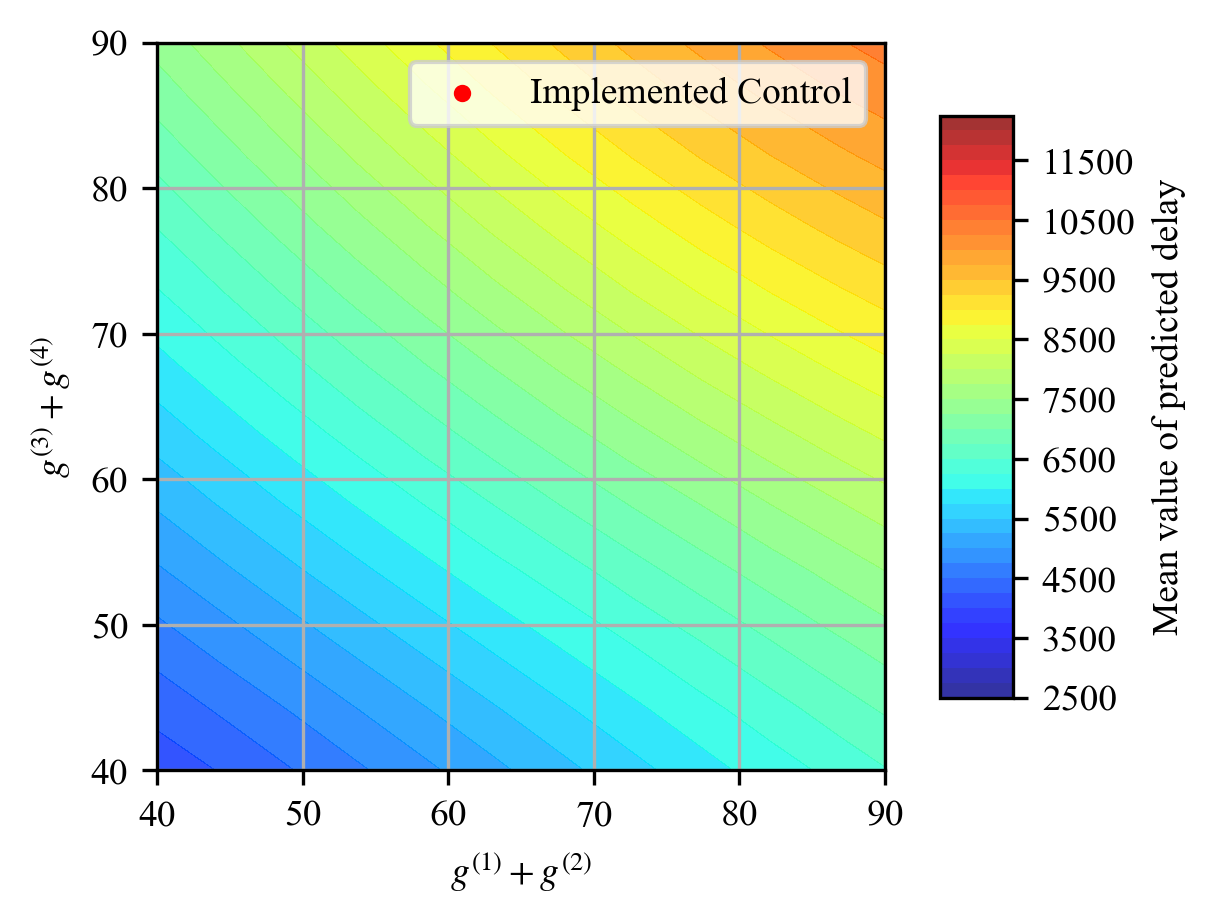

In [201]:
# 代理曲面
x = np.linspace(30,120,num)  # 调整范围

controls = np.load(output_dir+f'control_grid_{step_ahead}.npy')
res = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        tc = torch.from_numpy(controls[i,j]).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            res[i,j] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index-4-8],tc))[0,step_ahead]

fig,ax = plt.subplots()
X,Y = np.meshgrid(x,x)
tc = control2array(simulation_data['tc'][cycle_index-4:cycle_index])
x_lb = 15.0/(tc[step_ahead,[5,6,9,10]].min()/tc[step_ahead,[5,6]].sum())
x_ub = 60.0/(tc[step_ahead,[5,6,9,10]].max()/tc[step_ahead,[5,6]].sum())
y_lb = 15.0/(tc[step_ahead,[7,8,11,12]].min()/tc[step_ahead,[7,8]].sum())
y_ub = 60.0/(tc[step_ahead,[7,8,11,12]].max()/tc[step_ahead,[7,8]].sum())

ax.scatter(tc[step_ahead,[5,6]].sum(),tc[step_ahead,[7,8]].sum(),zorder=10,s=10.0,c='r',label='Implemented Control')
# ax.fill([60,120,120],[120,120,60],c='k',zorder=10,alpha=0.4)
# ax.fill([30,x_lb,x_lb,30],[30,30,120,120],c='k',zorder=10,alpha=0.4)
# ax.fill([120,x_ub,x_ub,120],[30,30,120,120],c='k',zorder=10,alpha=0.4)
# ax.fill([30,30,120,120],[30,y_lb,y_lb,30],c='k',zorder=10,alpha=0.4)
# ax.fill([30,30,120,120],[120,y_ub,y_ub,120],c='k',zorder=10,alpha=0.4)
levels = 250*np.arange(10,50)
contour = ax.contourf(X,Y,res,levels=levels,cmap=plt.cm.jet,alpha=0.8)
cbar=fig.colorbar(contour, shrink=0.8, aspect=8,alpha=0.8,label="Mean value of predicted delay")
ax.set_xticks(np.arange(30,120,10))
ax.set_yticks(np.arange(30,120,10))
ax.set_xlim([40,90])
ax.set_ylim([40,90])
ax.set_xlabel('$g^{(1)}+g^{(2)}$')
ax.set_ylabel('$g^{(3)}+g^{(4)}$')
ax.set_aspect('equal')
ax.legend()
fig.savefig(output_dir+f'res_pred_gird_{step_ahead}.jpg',bbox_inches='tight')

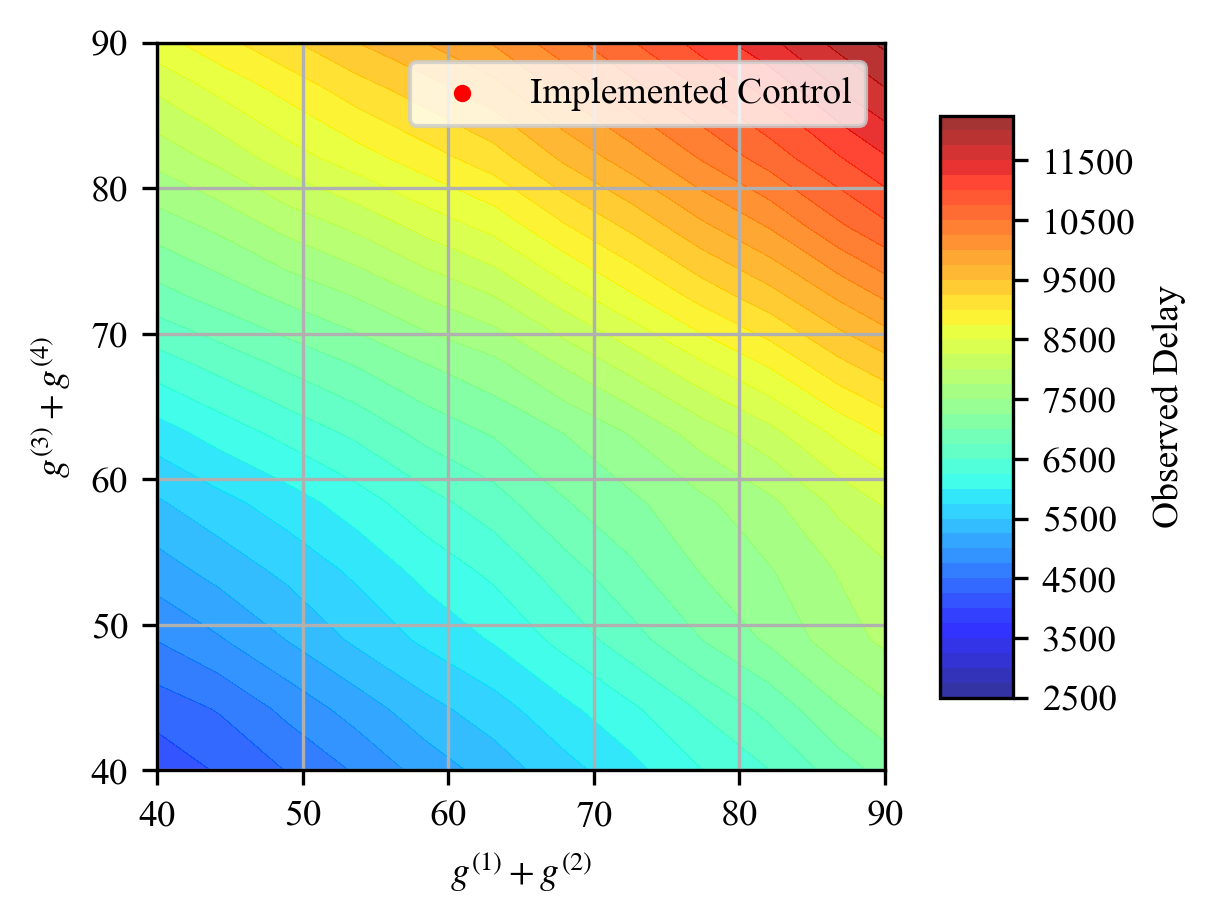

In [202]:
# 真实曲面
x = np.linspace(30,120,num)  # 调整范围

with open(output_dir+f"res_grid_{step_ahead}.npy",'rb') as f:
    res = np.load(f)

fig,ax = plt.subplots()
X,Y = np.meshgrid(x,x)
tc = control2array(simulation_data['tc'][cycle_index-4:cycle_index])
x_lb = 15.0/(tc[step_ahead,[5,6,9,10]].min()/tc[step_ahead,[5,6]].sum())
x_ub = 60.0/(tc[step_ahead,[5,6,9,10]].max()/tc[step_ahead,[5,6]].sum())
y_lb = 15.0/(tc[step_ahead,[7,8,11,12]].min()/tc[step_ahead,[7,8]].sum())
y_ub = 60.0/(tc[step_ahead,[7,8,11,12]].max()/tc[step_ahead,[7,8]].sum())

ax.scatter(tc[step_ahead,[5,6]].sum(),tc[step_ahead,[7,8]].sum(),zorder=4,s=10.0,c='r',label='Implemented Control')
# ax.fill(np.array([60,120,120]),np.array([120,120,60]),c='k',zorder=10,alpha=0.4)
# ax.fill([60,120,120],[120,120,60],c='k',zorder=10,alpha=0.4)
# ax.fill([30,x_lb,x_lb,30],[30,30,120,120],c='k',zorder=10,alpha=0.4)
# ax.fill([120,x_ub,x_ub,120],[30,30,120,120],c='k',zorder=10,alpha=0.4)
# ax.fill([30,30,120,120],[30,y_lb,y_lb,30],c='k',zorder=10,alpha=0.4)
# ax.fill([30,30,120,120],[120,y_ub,y_ub,120],c='k',zorder=10,alpha=0.4)

levels = 250*np.arange(10,50)
contour = ax.contourf(X,Y,res,levels=levels,cmap=plt.cm.jet,alpha=0.8)
cbar=fig.colorbar(contour,shrink=0.8,aspect=8,alpha=0.8,label="Observed Delay")
ax.set_xticks(np.arange(30,120,10))
ax.set_yticks(np.arange(30,120,10))
ax.set_xlim([40,90])
ax.set_ylim([40,90])
ax.set_xlabel('$g^{(1)}+g^{(2)}$')
ax.set_ylabel('$g^{(3)}+g^{(4)}$')
ax.set_aspect('equal')
ax.legend()
fig.savefig(output_dir+f'res_true_gird_{step_ahead}.jpg',bbox_inches='tight')

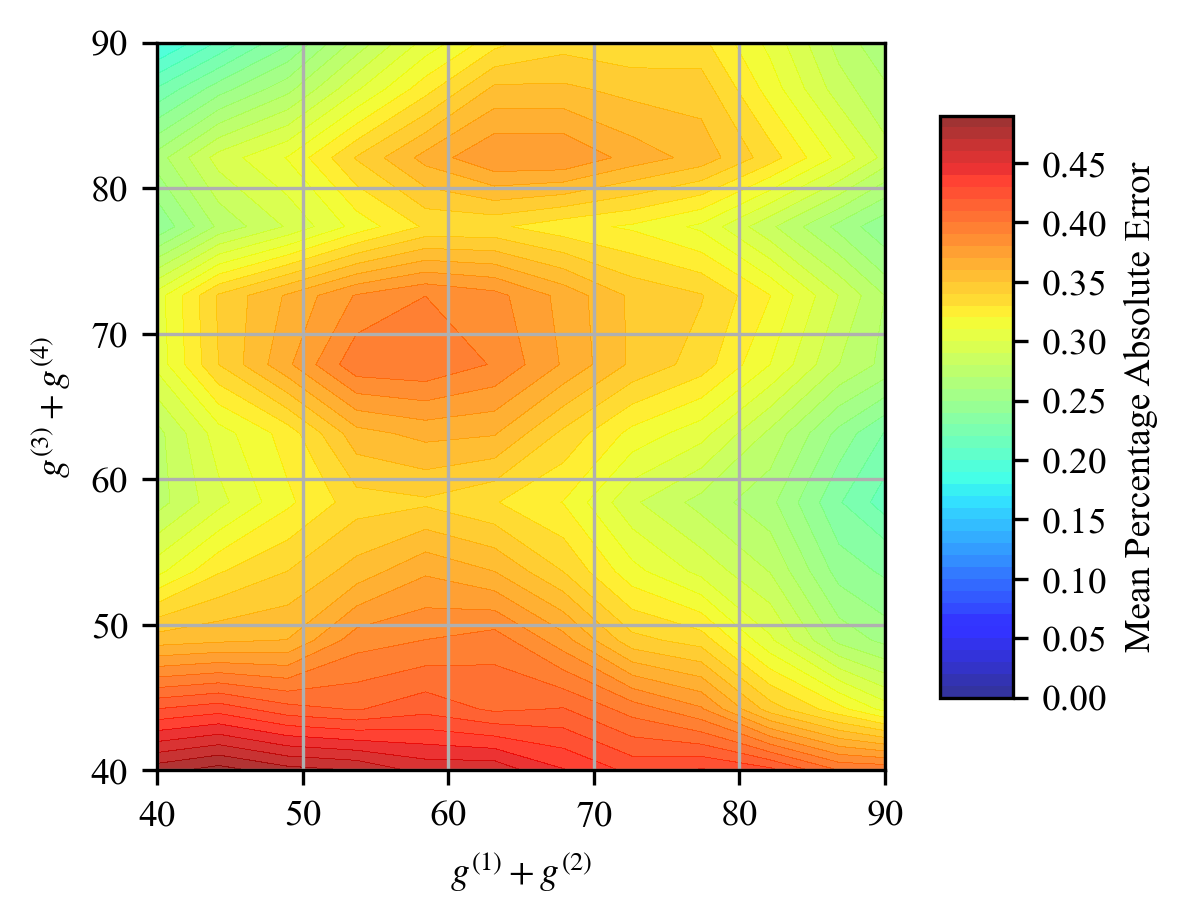

In [228]:
# 对比分析
x = np.linspace(30,120,num)  # 调整范围

controls = np.load(output_dir+f'control_grid_{step_ahead}.npy')
res_pred = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        tc = torch.from_numpy(controls[i,j]).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            res_pred[i,j] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index],tc))[0,step_ahead]
            
with open(output_dir+f"res_grid_{step_ahead}.npy",'rb') as f:
    res_true = np.load(f)
    
fig,ax = plt.subplots()
X,Y = np.meshgrid(x,x)
tc = control2array(simulation_data['tc'][cycle_index-4:cycle_index])
x_lb = 15.0/(tc[step_ahead,[5,6,9,10]].min()/tc[step_ahead,[5,6]].sum())
x_ub = 60.0/(tc[step_ahead,[5,6,9,10]].max()/tc[step_ahead,[5,6]].sum())
y_lb = 15.0/(tc[step_ahead,[7,8,11,12]].min()/tc[step_ahead,[7,8]].sum())
y_ub = 60.0/(tc[step_ahead,[7,8,11,12]].max()/tc[step_ahead,[7,8]].sum())

# ax.scatter(tc[step_ahead,[5,6]].sum(),tc[step_ahead,[7,8]].sum(),zorder=4,s=10.0,c='r',label='Implemented Control')
# ax.fill(np.array([60,120,120]),np.array([120,120,60]),c='k',zorder=10,alpha=0.4)
# ax.fill([60,120,120],[120,120,60],c='k',zorder=10,alpha=0.4)
# ax.fill([30,x_lb,x_lb,30],[30,30,120,120],c='k',zorder=10,alpha=0.4)
# ax.fill([120,x_ub,x_ub,120],[30,30,120,120],c='k',zorder=10,alpha=0.4)
# ax.fill([30,30,120,120],[30,y_lb,y_lb,30],c='k',zorder=10,alpha=0.4)
# ax.fill([30,30,120,120],[120,y_ub,y_ub,120],c='k',zorder=10,alpha=0.4)

levels = np.arange(0,0.5,0.01)
contour = ax.contourf(X,Y,np.abs(res_pred-res_true)/res_true,levels=levels,cmap=plt.cm.jet,alpha=0.8)
cbar=fig.colorbar(contour,shrink=0.8, aspect=8,alpha=0.8,label="Mean Percentage Absolute Error")
ax.set_xticks(np.arange(30,120,10))
ax.set_yticks(np.arange(30,120,10))
ax.set_xlim([40,90])
ax.set_ylim([40,90])
ax.set_xlabel('$g^{(1)}+g^{(2)}$')
ax.set_ylabel('$g^{(3)}+g^{(4)}$')
ax.set_aspect('equal')
fig.savefig(output_dir+f'res_error_gird_{step_ahead}.jpg',bbox_inches='tight')

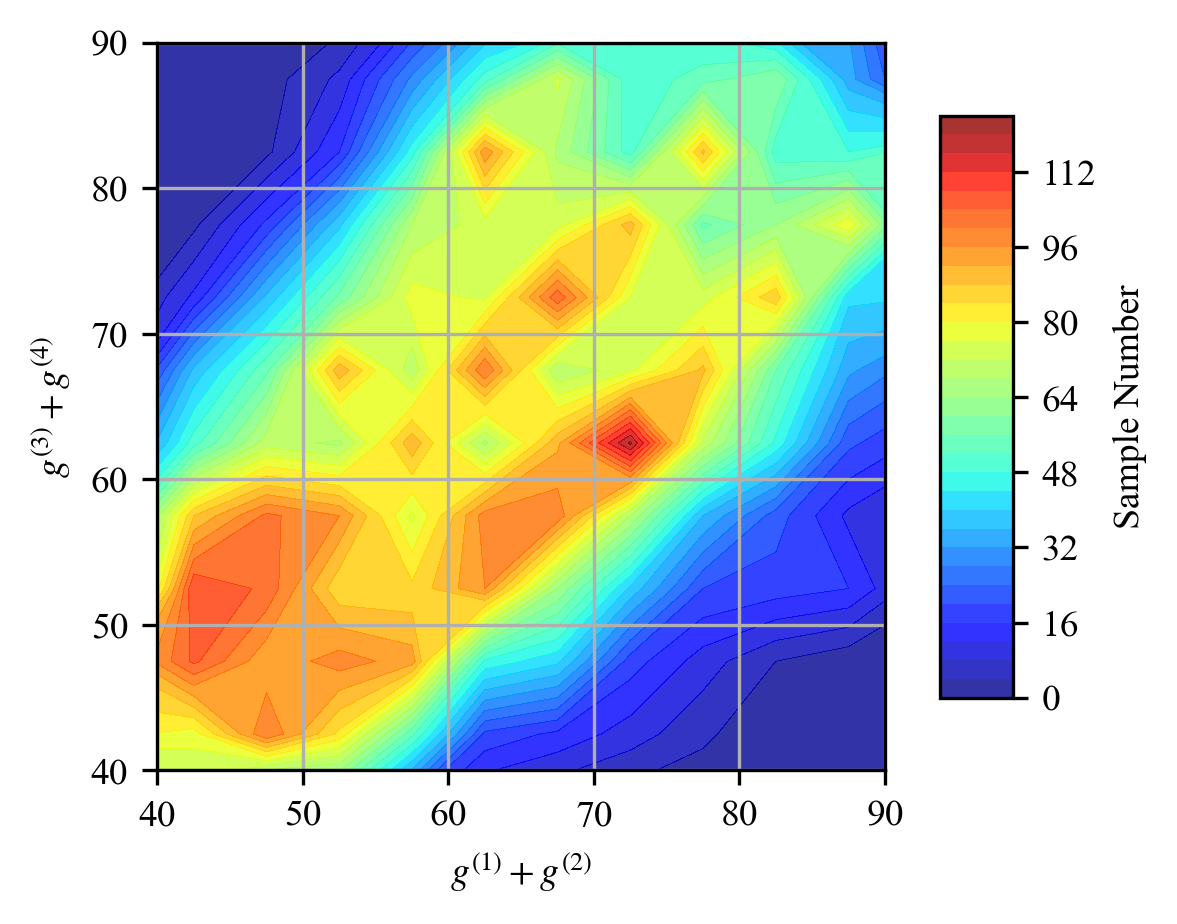

In [204]:
# 数据密度曲面
mg_1,mg_2 = tuple(np.load('../results/experiment/dataset/grid_data.npz').values())

fig,ax = plt.subplots()
h,x,y,_ = ax.hist2d(mg_1[:,step_ahead],mg_2[:,step_ahead],
                        bins=20,cmap=plt.cm.jet,alpha=0.0,range=2*[[25,125]])
x,y = (x[:-1] + x[1:])/2,(y[:-1] + y[1:])/2
X,Y = np.meshgrid(x,y)
contour = ax.contourf(X,Y,h,levels=30,cmap=plt.cm.jet,alpha=0.8)
cbar=fig.colorbar(contour,shrink=0.8,aspect=8,alpha=0.8,label="Sample Number")
ax.set_xticks(np.arange(30,120,10))
ax.set_yticks(np.arange(30,120,10))
ax.set_xlim([40,90])
ax.set_ylim([40,90])
ax.set_xlabel('$g^{(1)}+g^{(2)}$')
ax.set_ylabel('$g^{(3)}+g^{(4)}$')
ax.set_aspect('equal')
fig.savefig('../results/experiment/dataset/data_grid_train.jpg',bbox_inches='tight')

##### 绿灯比例调整

In [19]:
# 间隔构建
x = np.linspace(0,1,num)  # 调整范围

pbar = tqdm(total=num*num,desc='Processing')
controls = np.zeros((num,num,4,13))
for i,x1 in enumerate(x):
        pbar.update(1)
        control = control2array(simulation_data['tc'][cycle_index-4:cycle_index])  # (lookahead,13)
        control[step_ahead,[5,6,9,10]] *= x1/control[step_ahead,[5,6]].sum()
        controls[i,j] = control[:]

np.save(output_dir+f'control_curve_{step_ahead}.npy',controls)

Processing: 100%|██████████| 400/400 [1:08:12<00:00, 10.23s/it]


(60.0, 180.0)

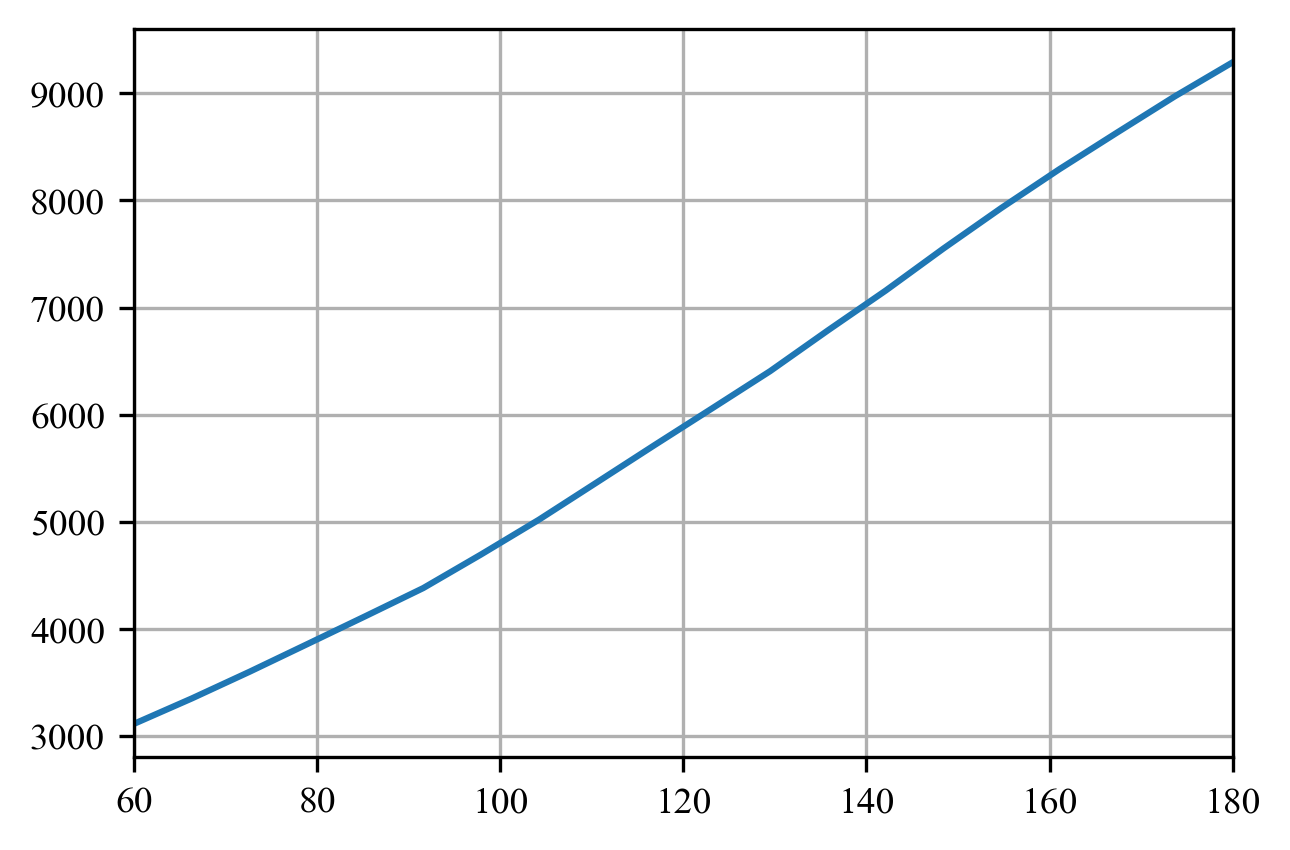

In [20]:
# 代理曲线
x = np.linspace(60,180,num)  # 调整范围

controls = np.load(output_dir+'control_curve.npy')
res = np.zeros(num)
for i in range(num):
    tc = torch.from_numpy(controls[i]).to(torch.float32).unsqueeze(0)
    with torch.no_grad():
        res[i] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index],tc))[0,step_ahead]

fig,ax = plt.subplots()
ax.plot(x,res)
ax.set_xlim([60,180])

In [ ]:
# 真实曲线
with open(output_dir+"res_curve.npy",'rb') as f:
    res = np.load(f)
    
fig,ax = plt.subplots()
ax.plot(x,res)
ax.set_xlim([60,180])

##### 相序遍历

In [16]:
# 生成相序
phase_list = []
for i in range(2**5):
    phase_list.append(np.array([(i//2**4)%2, (i//2**3)%2, (i//2**2)%2, (i//2**1)%2, (i//2**0)%2]))

controls = np.zeros((len(phase_list),4,13))
for i,phase in enumerate(phase_list):    
    control = control2array(simulation_data['tc'][cycle_index-4:cycle_index])  # (lookahead,13)    
    control[step_ahead,:5] = phase
    controls[i] = control[:]
    
np.save(output_dir+f'control_phase_{step_ahead}.npy',controls)

Text(0, 0.5, 'Delay')

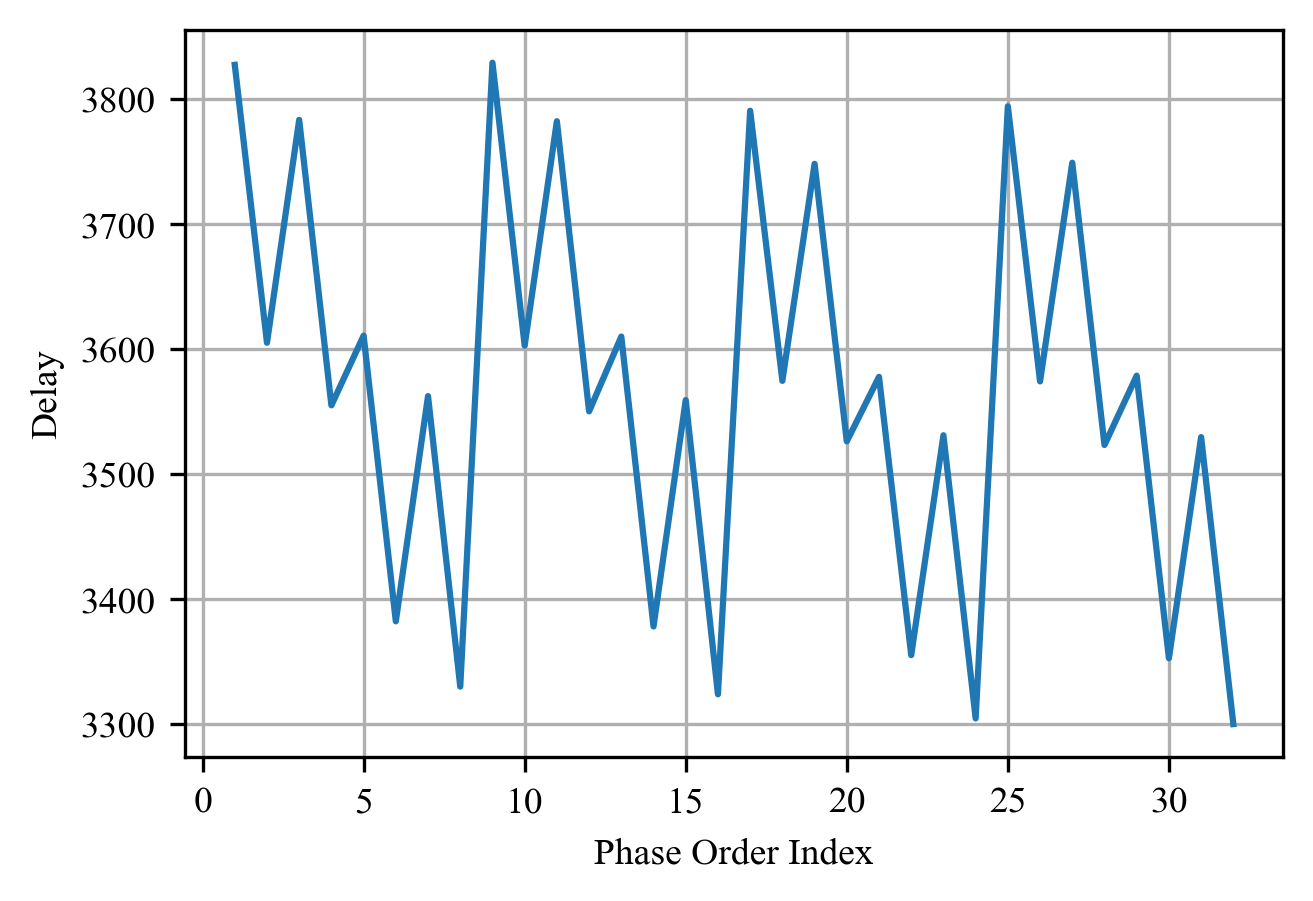

In [17]:
# 代理延误
controls = np.load(output_dir+f'control_phase_{step_ahead}.npy')

res = np.zeros(len(phase_list))
for i in range(len(phase_list)):
    tc = torch.from_numpy(controls[i]).to(torch.float32).unsqueeze(0)
    with torch.no_grad():
        res[i] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index-4-8],tc))[0,step_ahead]

fig,ax = plt.subplots()
ax.plot(1+np.arange(32,dtype=int),res)
ax.set_xlabel('Phase Order Index')
ax.set_ylabel('Delay')

Text(0, 0.5, 'Delay')

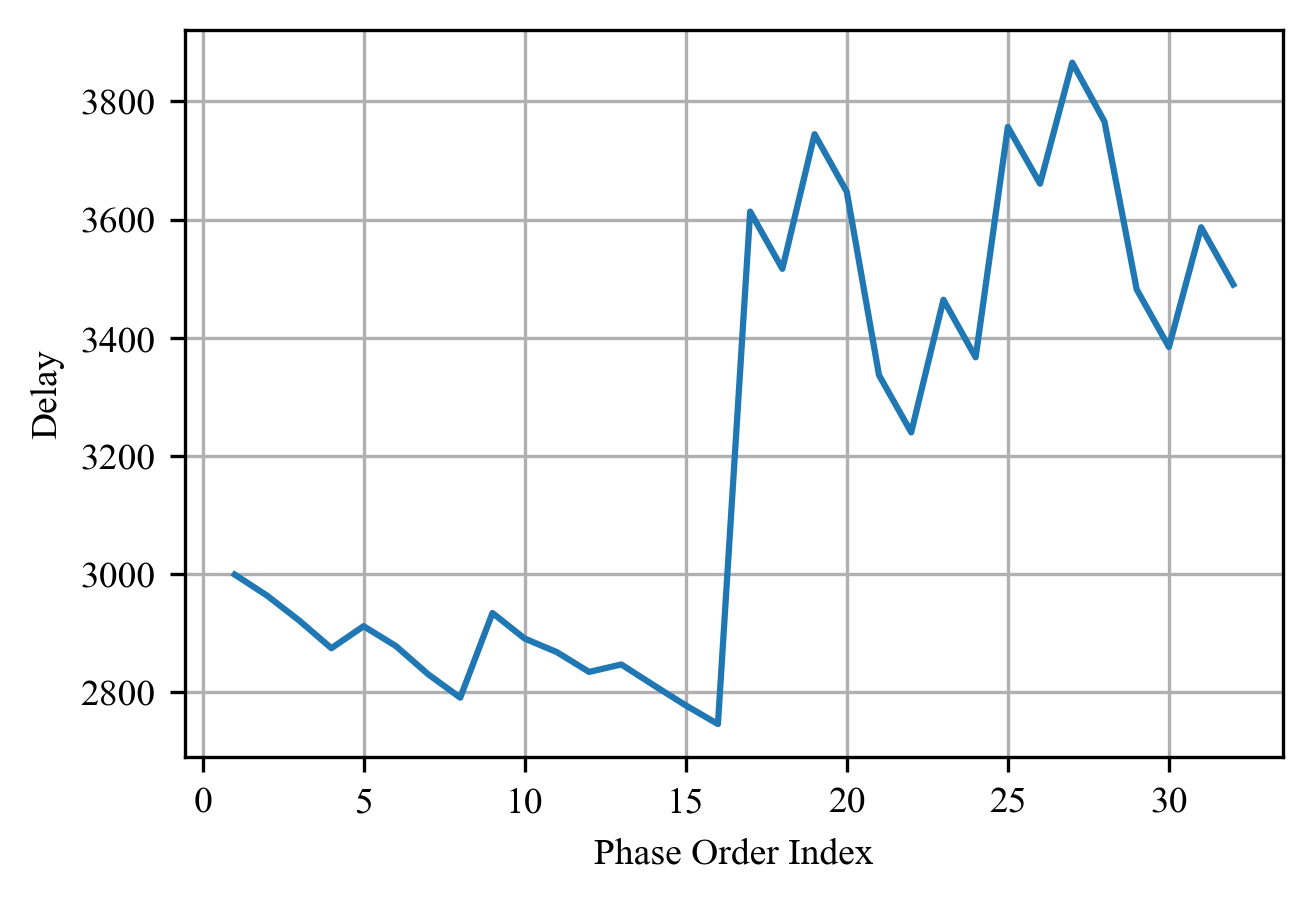

In [18]:
# 真实延误
with open(output_dir+f"res_phase_{step_ahead}.npy",'rb') as f:
    res = np.load(f)

fig,ax = plt.subplots()
ax.plot(1+np.arange(32,dtype=int),res)
ax.set_xlabel('Phase Order Index')
ax.set_ylabel('Delay')

(2000.0, 6000.0)

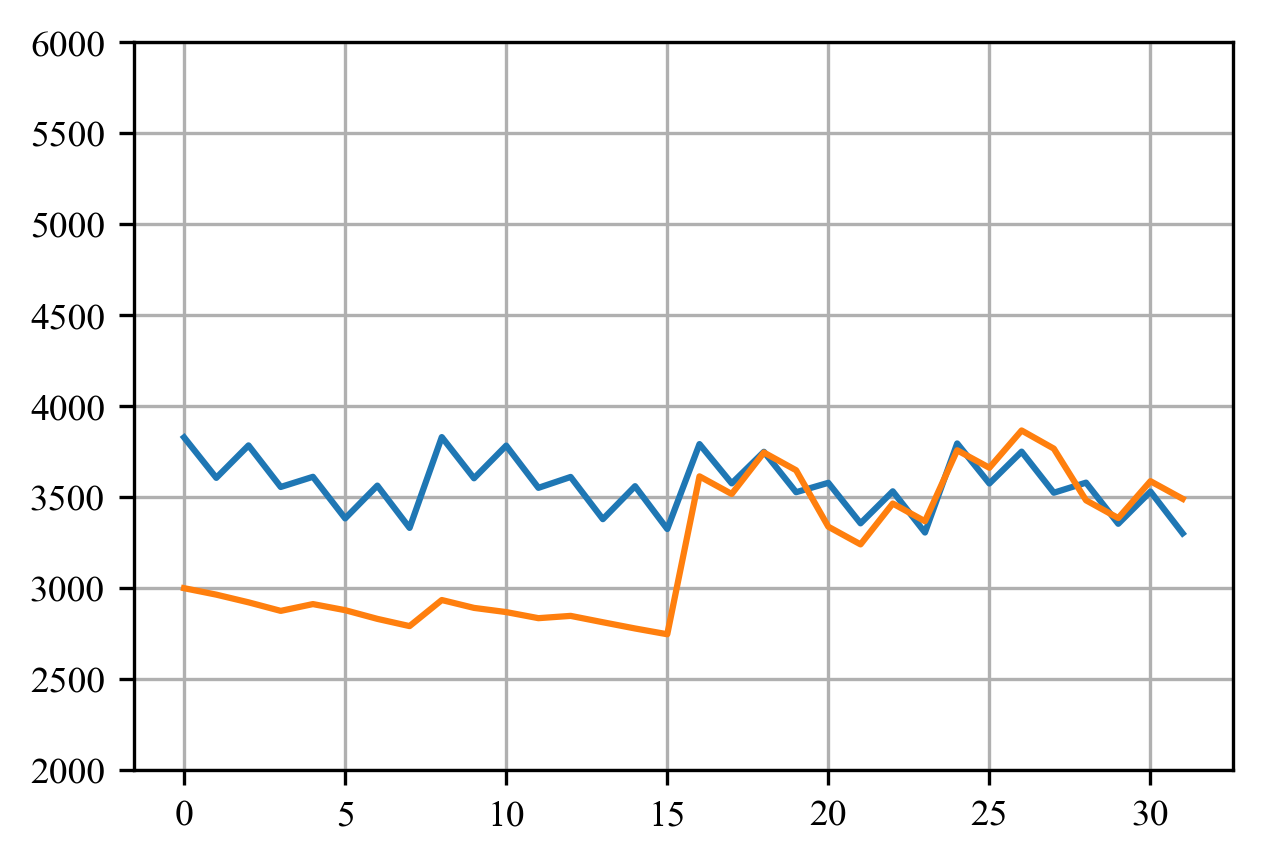

In [19]:
# 对比分析
controls = np.load(output_dir+f'control_phase_{step_ahead}.npy')
res_pred = np.zeros(len(phase_list))
for i in range(len(phase_list)):
    tc = torch.from_numpy(controls[i]).to(torch.float32).unsqueeze(0)
    with torch.no_grad():
        res_pred[i] = mdn_mean(mpc_data['surrogate_model'].predict(mpc_data['context_result'][cycle_index-4-8],tc))[0,step_ahead]
        
with open(output_dir+f"res_phase_{step_ahead}.npy",'rb') as f:
    res_true = np.load(f)
    
fig,ax = plt.subplots()
ax.plot(res_pred,label='Mean Prediction')
ax.plot(res_true,label='True Delay')
ax.set_ylim([2000,6000])

##### 仿真过程代理可视化

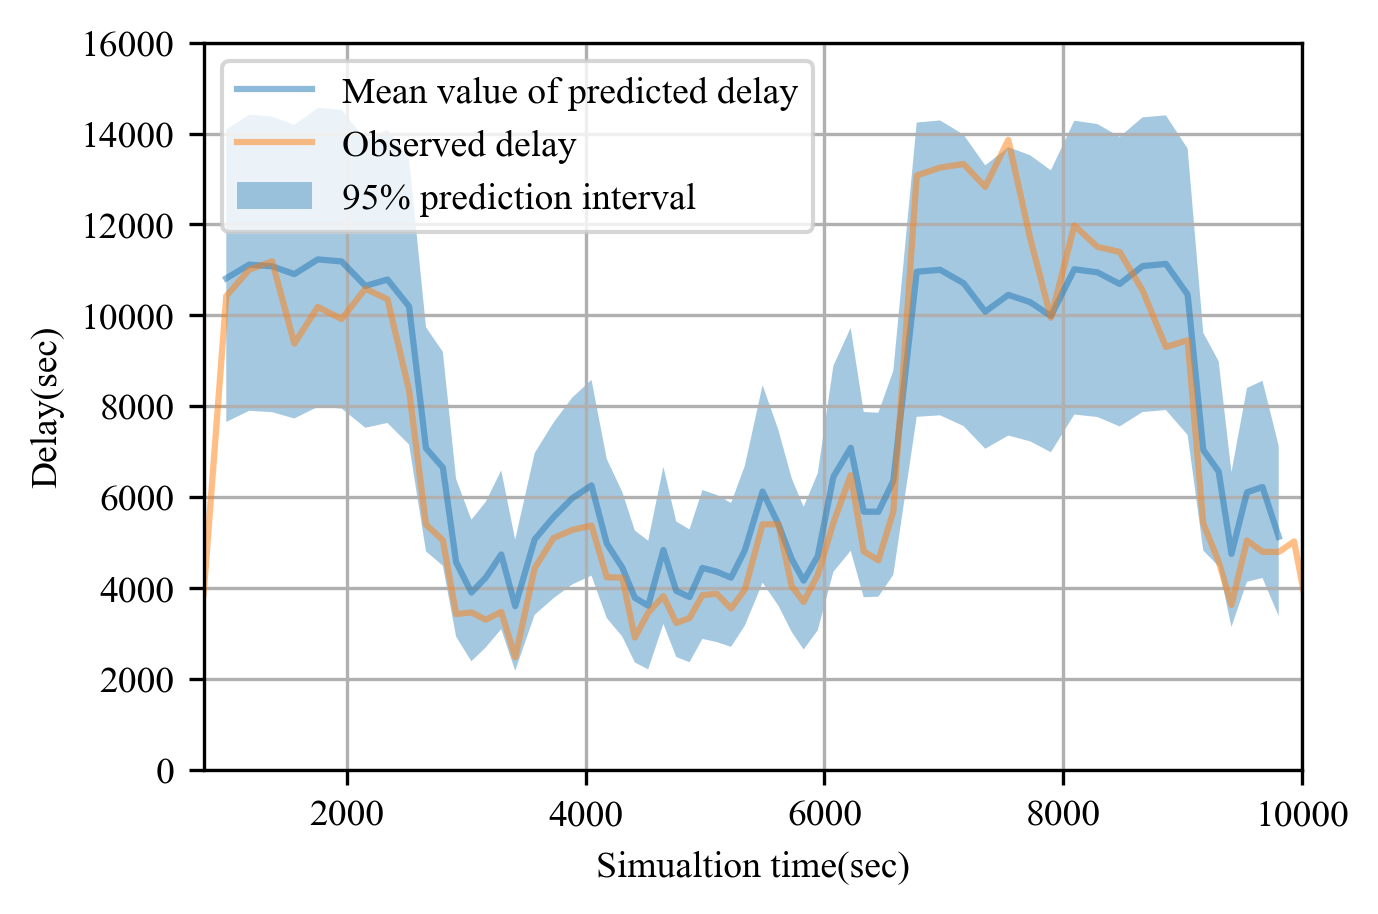

In [217]:
# Delay with Reliability
def discounted(timeloss):
    # 输入一个周期内各个流向各秒的timeloss, (time,inlet,movement)
    num = timeloss.shape[0]
    weight = np.logspace(start=0,stop=num,num=num,base=0.999)
    return (timeloss.sum((-1,-2))*weight).sum()

step_ahead = 0

fig,ax = plt.subplots()
x = timestamp_data

# mean
for step in [step_ahead]:
    y = []
    for i in range(8,len(timestamp_data)-4):
        tc = torch.from_numpy(control2array(simulation_data['tc'][i:i+4])).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            y_pred = mpc_data['surrogate_model'].predict(mpc_data['context_result'][i-8],tc)
            y.append(mdn_mean(y_pred)[0][step].item())
    ax.plot(x[8+step:-4+step],y,alpha=0.5,label=f"Mean value of predicted delay")

# truth
y = [discounted(d) for d in simulation_data['timeloss']]
ax.plot(x,y,alpha=0.5,label='Observed delay')

# prediction interval
for step in [step_ahead]:
    y_ub = []
    y_lb = []
    z = 0.95*np.ones(1)
    for i in range(8,len(timestamp_data)-4):
        tc = torch.from_numpy(control2array(simulation_data['tc'][i:i+4])).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            c,mu,sigma = mpc_data['surrogate_model'].predict(mpc_data['context_result'][i-8],tc)
            c,mu,sigma = c[0,step].numpy(),mu[0,step].numpy(),sigma[0,step].numpy()
            lb,ub = prediction_interval((c,mu,sigma),z)
            y_lb.append(lb)
            y_ub.append(ub)
    ax.fill_between(x[8+step:-4+step],y_lb,y_ub,alpha=0.4,label=f"{int(100*z.squeeze())}% prediction interval")

ax.legend()
ax.set_ylim([0,16000])
ax.set_xlim([800,10000])
ax.set_xlabel('Simualtion time(sec)')
ax.set_ylabel('Delay(sec)')
fig.savefig(result_dir+f'res_delay_reliability_{step_ahead}.jpg',bbox_inches='tight')

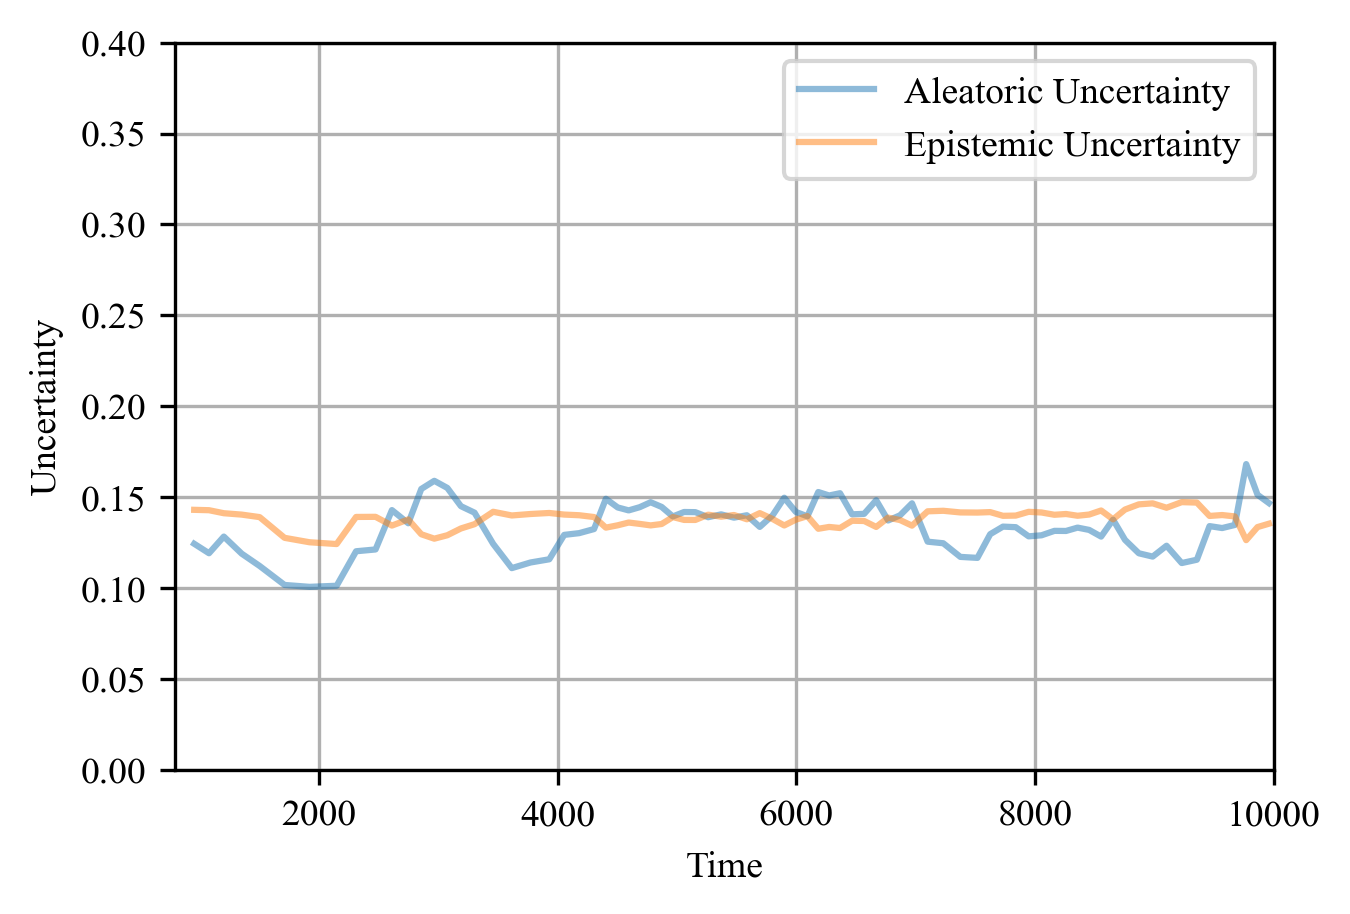

In [96]:
# Delay and Uncertainty
def discounted(timeloss):
    # 输入一个周期内各个流向各秒的timeloss, (time,inlet,movement)
    num = timeloss.shape[0]
    weight = np.logspace(start=0,stop=num,num=num,base=0.999)
    return (timeloss.sum((-1,-2))*weight).sum()

step_ahead = 0

fig,ax = plt.subplots()
x = timestamp_data
# y = [discounted(d) for d in simulation_data['timeloss']]
# ax.plot(x,y,alpha=0.5,label='True Delay',c='k')

# aleatoric uncertainty
for step in [step_ahead]:
    y = []
    for i in range(8,len(timestamp_data)-4):
        tc = torch.from_numpy(control2array(simulation_data['tc'][i:i+4])).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            y_pred = mpc_data['surrogate_model'].predict(mpc_data['context_result'][i-8],tc)
            y.append(np.sqrt(aleatoric_uncertainty(y_pred)[0][step].item())/mdn_mean(y_pred)[0][step].item())
    ax.plot(x[8+step:-4+step],y,alpha=0.5,label=f"Aleatoric Uncertainty")

# epistemic uncertainty
for step in [step_ahead]:
    y = []
    for i in range(8,len(timestamp_data)-4):
        tc = torch.from_numpy(control2array(simulation_data['tc'][i:i+4])).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            y_pred = mpc_data['surrogate_model'].predict(mpc_data['context_result'][i-8],tc)
            y.append(np.sqrt(epistemic_uncertainty(y_pred)[0][step].item())/mdn_mean(y_pred)[0][step].item())
    ax.plot(x[8+step:-4+step],y,alpha=0.5,label=f"Epistemic Uncertainty")

ax.set_xlim([800,10000])
ax.set_ylim([0,0.4])
ax.set_xlabel('Time')

ax.set_ylabel('Uncertainty')

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
fig.savefig(result_dir+f'res_delay_uncertainty_{step_ahead}.jpg',bbox_inches='tight')

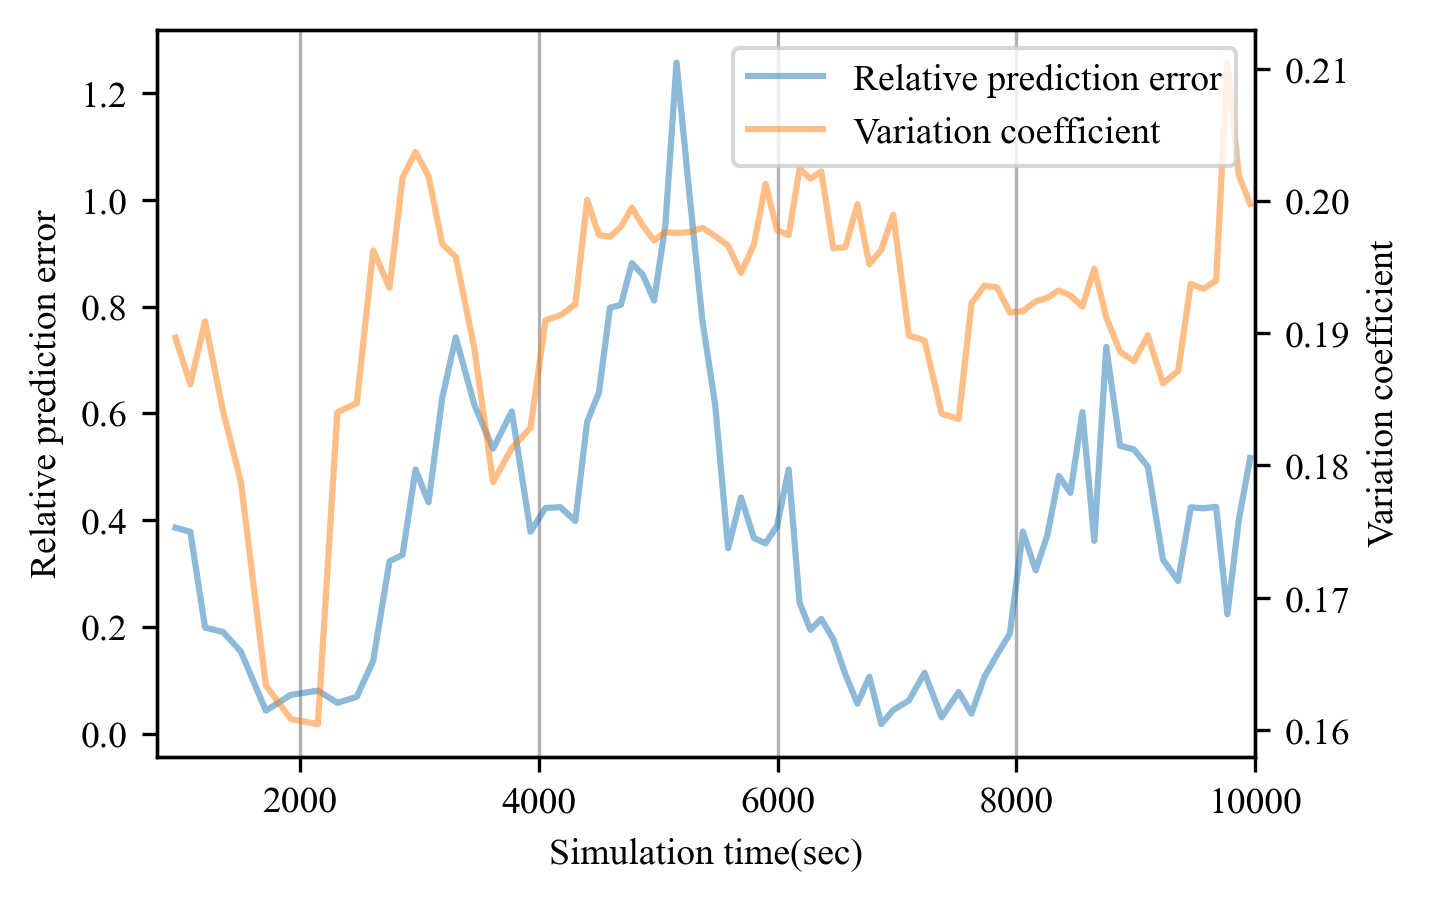

In [151]:
#  Delay with Error
def discounted(timeloss):
    # 输入一个周期内各个流向各秒的timeloss, (time,inlet,movement)
    num = timeloss.shape[0]
    weight = np.logspace(start=0,stop=num,num=num,base=0.999)
    return (timeloss.sum((-1,-2))*weight).sum()

step_ahead = 0

fig,ax = plt.subplots()
x = timestamp_data

# truth
y_p = [discounted(d) for d in simulation_data['timeloss']]
y_p = y_p[8+step_ahead:-4+step_ahead]

# mean delay prediction error
for step in [step_ahead]:
    y = []
    for i in range(8,len(timestamp_data)-4):
        tc = torch.from_numpy(control2array(simulation_data['tc'][i:i+4])).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            y_pred = mpc_data['surrogate_model'].predict(mpc_data['context_result'][i-8],tc)
            y.append(mdn_mean(y_pred)[0][step].item())
    ax.plot(x[8+step:-4+step],np.abs(np.array(y)-np.array(y_p))/np.array(y_p),alpha=0.5,label=f"Relative prediction error",c='#1f77b4')

ax1 = ax.twinx()
# uncertainty
for step in [step_ahead]:
    y = []
    for i in range(8,len(timestamp_data)-4):
        tc = torch.from_numpy(control2array(simulation_data['tc'][i:i+4])).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            y_pred = mpc_data['surrogate_model'].predict(mpc_data['context_result'][i-8],tc)
            y.append(np.sqrt(variance(y_pred)[0][step].item())/mdn_mean(y_pred)[0][step].item())
            # y.append(aleatoric_uncertainty(y_pred)[0][step].item())
    ax1.plot(x[8+step:-4+step],y,alpha=0.5,label=f"Variation coefficient",c='#ff7f0e')

# ax.set_ylim([1000,16000])
ax.set_xlim([800,10000])
ax.set_xlabel('Simulation time(sec)')
ax.set_ylabel('Relative prediction error')
ax1.set_ylabel('Variation coefficient')
ax.grid(axis='y')
ax1.grid(axis='y')
# ax.set_ylim([0,None])
# ax1.set_ylim([0.14,None])
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
fig.savefig(result_dir+f'res_error_var_{step_ahead}.jpg',bbox_inches='tight')

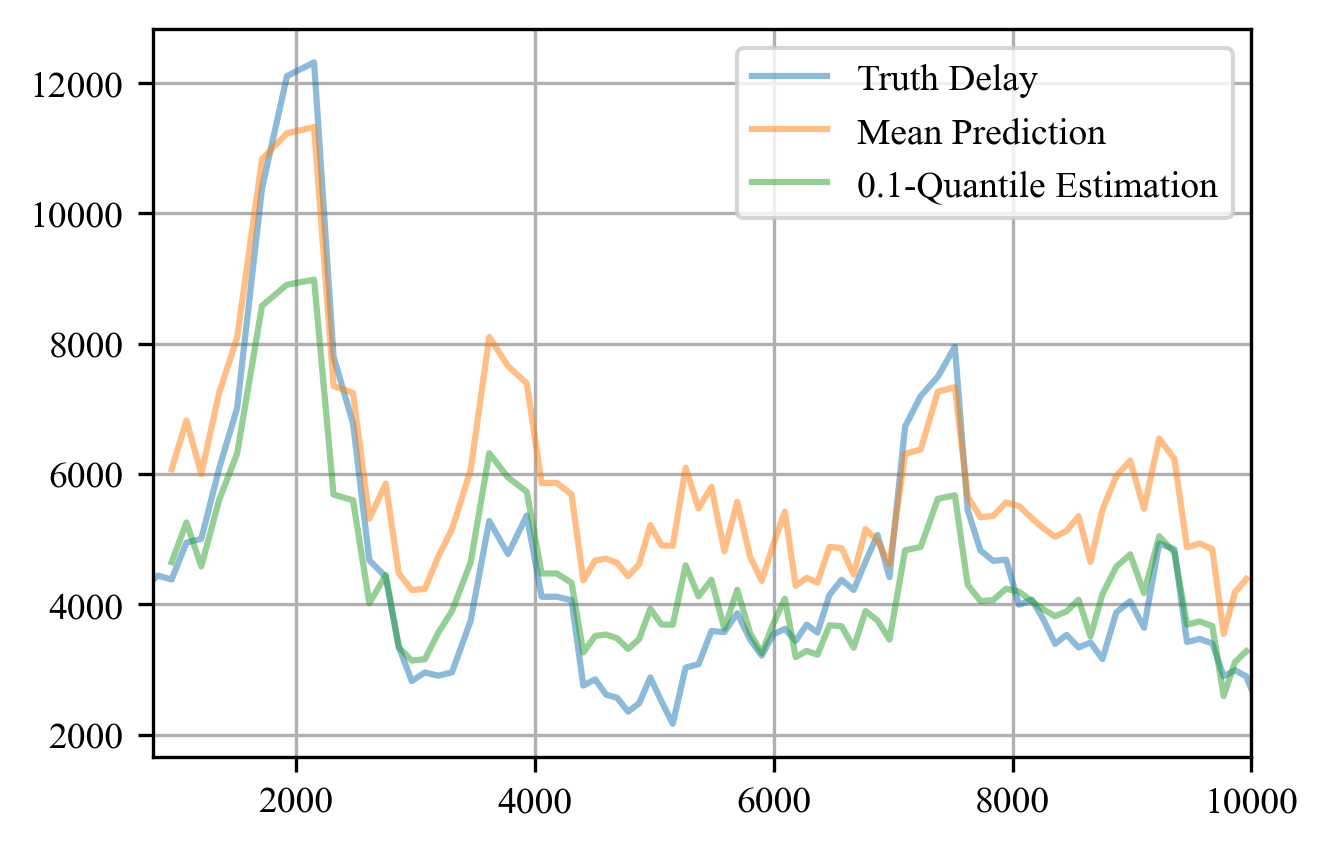

In [173]:
# Delay and quantile
def discounted(timeloss):
    # 输入一个周期内各个流向各秒的timeloss, (time,inlet,movement)
    num = timeloss.shape[0]
    weight = np.logspace(start=0,stop=num,num=num,base=0.999)
    return (timeloss.sum((-1,-2))*weight).sum()

step_ahead = 0

fig,ax = plt.subplots()
x = timestamp_data
y = [discounted(d) for d in simulation_data['timeloss']]
ax.plot(x,y,alpha=0.5,label='Truth Delay')

# mean
for step in [step_ahead]:
    y = []
    for i in range(8,len(timestamp_data)-4):
        tc = torch.from_numpy(control2array(simulation_data['tc'][i:i+4])).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            y_pred = mpc_data['surrogate_model'].predict(mpc_data['context_result'][i-8],tc)
            y.append(mdn_mean(y_pred)[0][step].item())
    ax.plot(x[8:-4],y,alpha=0.5,label=f"Mean Prediction")

# quantile
for step in [step_ahead]:
    y = []
    q = 0.10*np.ones(1)
    for i in range(8,len(timestamp_data)-4):
        tc = torch.from_numpy(control2array(simulation_data['tc'][i:i+4])).to(torch.float32).unsqueeze(0)
        with torch.no_grad():
            c,mu,sigma = mpc_data['surrogate_model'].predict(mpc_data['context_result'][i-8],tc)
            c,mu,sigma = c[0,step].numpy(),mu[0,step].numpy(),sigma[0,step].numpy()
            y.append(quantile((c,mu,sigma),q))
    ax.plot(x[8:-4],y,alpha=0.5,label=f"{q[0]}-Quantile Estimation")

ax.legend()
ax.set_xlim([800,10000])
fig.savefig(result_dir+f'res_delay_quantile_{step_ahead}.jpg',bbox_inches='tight')

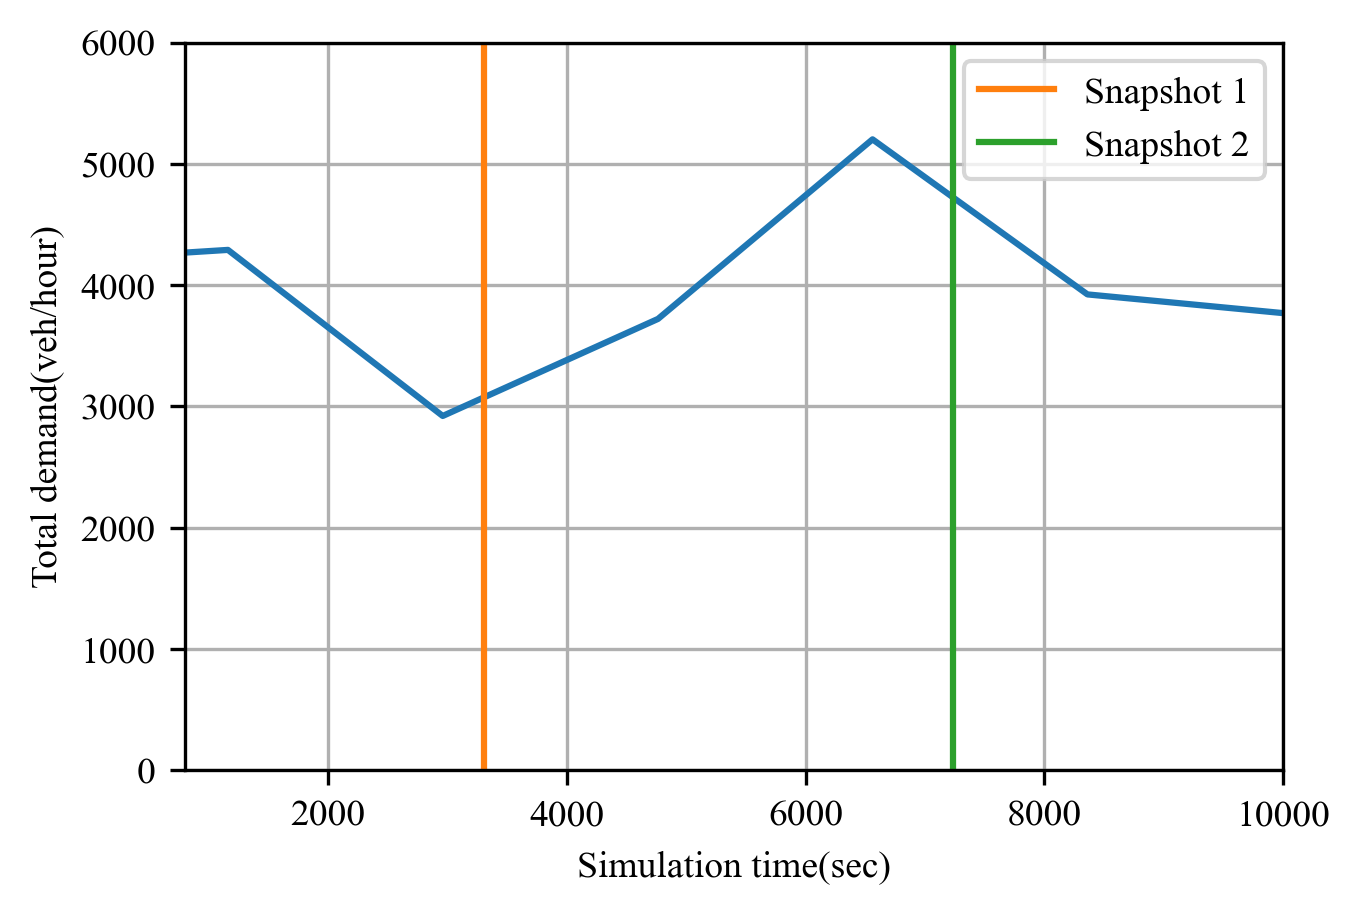

In [208]:
# demand curve
fig,ax = plt.subplots()
y = mpc_data['demand'][:].sum((-1,-2))
ax.plot(y)
ax.plot(2*[timestamp_data[24]],[0,8000],label='Snapshot 1')
ax.plot(2*[timestamp_data[60]],[0,8000],label='Snapshot 2')
# ax.plot(2*[timestamp_data[28]],[0,8000],label='Snapshot 3')
ax.set_xlim([800,10000])
ax.set_ylim([0,6000])
ax.set_xlabel('Simulation time(sec)')
ax.set_ylabel('Total demand(veh/hour)')
ax.legend()
fig.savefig(result_dir+'res_demand.jpg',bbox_inches='tight')